# Hard magnet tutorial – with AI-based property predictions

## Introduction

- This notebook demonstrates how to use the `mammos-ai` package to predict hard magnet properties using pre-trained machine learning models.
- This is the same workflow as the [hard magnet tutorial](./hard-magnet-tutorial.ipynb) but uses AI models to predict hysteresis properties instead of micromagnetic simulations.


Requirements:
- Software: `mammos`
- Basic understanding of [hard magnet tutorial](./hard-magnet-tutorial.ipynb)

In [1]:
%config InlineBackend.figure_format = "retina"


import mammos_ai
import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## Load data from DFT and spindynamics databases

In [3]:
material = "Co2Fe2H4"

results_dft = mammos_dft.db.get_micromagnetic_properties(material)
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization(material)

## Calculate micromagnetic intrinsic properties using Kuz’min formula

In [4]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.Ku_0,
)

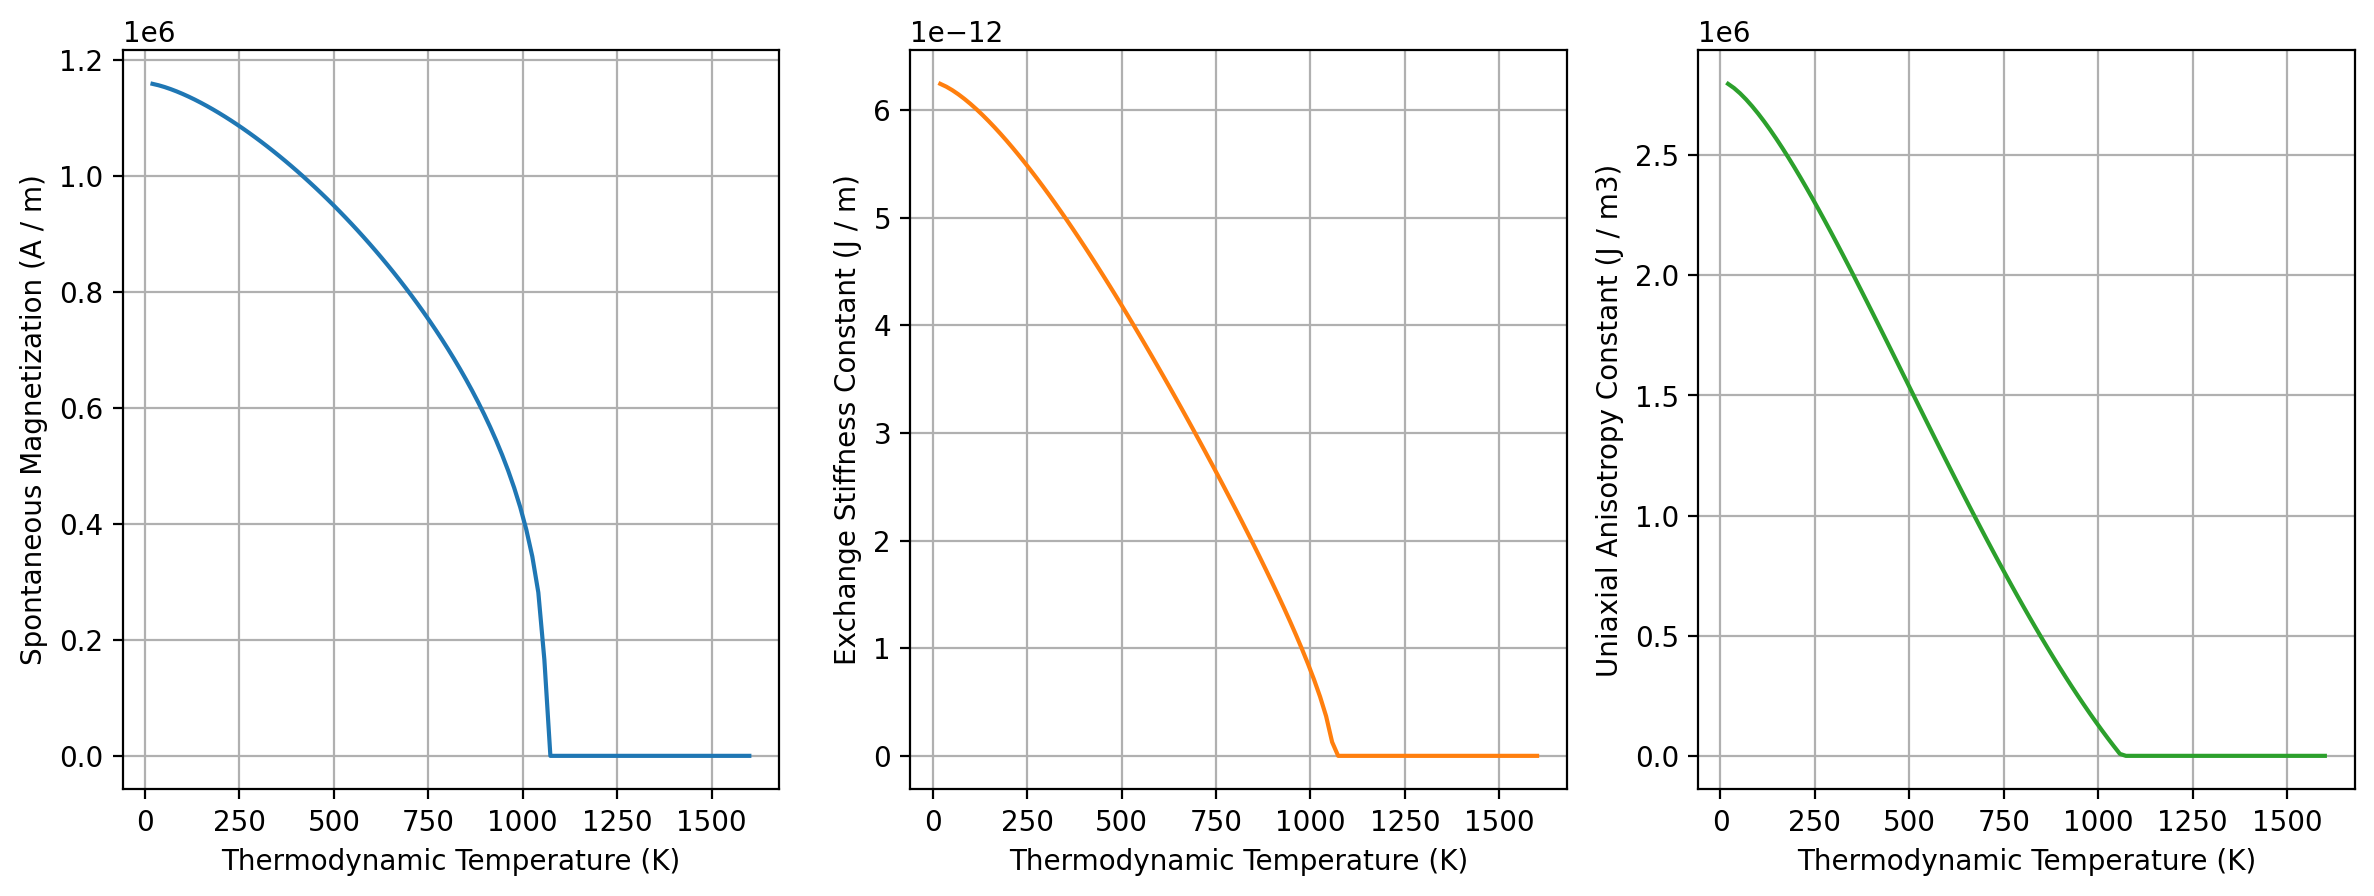

In [5]:
results_kuzmin.plot();

## AI-based prediction of extrinsic properties
Rather than running micromagnetic simulations to compute hysteresis loops and derive extrinsic properties such as coercive field Hc and maximum energy product BHmax, we use pre-trained machine learning models from the `mammos-ai` package.

Details about the models and their training data can be found in the [mammos-ai documentation](https://mammos-project.github.io/mammos/api/mammos_ai.html).

This approach allows for rapid predictions of hysteresis properties based on the intrinsic micromagnetic parameters computed earlier.

The model has been trained on a 50 x 50 x 50 nm cubic grain with uniaxial anisotropy and external magnetic field applied along the cube's edge.

In [6]:
T = np.linspace(0, 1.1 * results_kuzmin.Tc.q, 20)

results_ml = mammos_ai.Hc_Mr_BHmax_from_Ms_A_K(
    Ms=results_kuzmin.Ms(T),
    A=results_kuzmin.A(T),
    K1=results_kuzmin.K1(T),
)

This has returned an `ExtrinsicProperties` object containing the predicted hysteresis properties. This is the same object type as returned by running micromagnetic simulations and them processing them with `mammos_analysis.hysteresis.extrinsic_properties` in the hard magnet tutorial.

In [7]:
results_ml

ExtrinsicProperties(Hc=Entity(ontology_label='CoercivityHcExternal', value=array([2942256.2  , 2857558.5  , 2740996.8  , 2543269.5  , 2428668.5  ,
       2208944.   , 2115859.   , 1819307.6  , 1808106.2  , 1698485.6  ,
       1829058.5  , 1429938.1  , 1091347.4  ,  903446.3  , 1116855.1  ,
       1057900.2  ,  966576.75 ,   17457.65 ,   17204.068,   17204.068],
      dtype=float32), unit='A / m'), Mr=Entity(ontology_label='Remanence', value=array([1142329.1  , 1137940.8  , 1132234.9  , 1115691.5  , 1108781.   ,
       1087777.1  , 1069930.6  , 1039830.7  ,  997795.75 ,  947130.56 ,
        841426.94 ,  782085.25 ,  755020.2  ,  736731.56 ,  618404.6  ,
        582873.56 ,  390627.44 ,   61490.266,   57923.465,   57923.465],
      dtype=float32), unit='A / m'), BHmax=Entity(ontology_label='MaximumEnergyProduct', value=array([409878.44, 406728.28, 402647.75, 390956.53, 386122.5 , 371605.25,
       359498.5 , 339515.28, 312623.38, 281647.78, 222328.2 , 192068.8 ,
       178941.03, 170193.

We can visualize the predicted extrinsic properties as a function of temperature:

Starting with Mr, we known that Mr for hard magnets is approximately Ms so we expect a similar temperature dependence. We can see that this is indeed the case however the AI model is not perfect, as Ms should be a hard upper limit for Mr and we see some predicted Mr values slightly exceeding Ms.

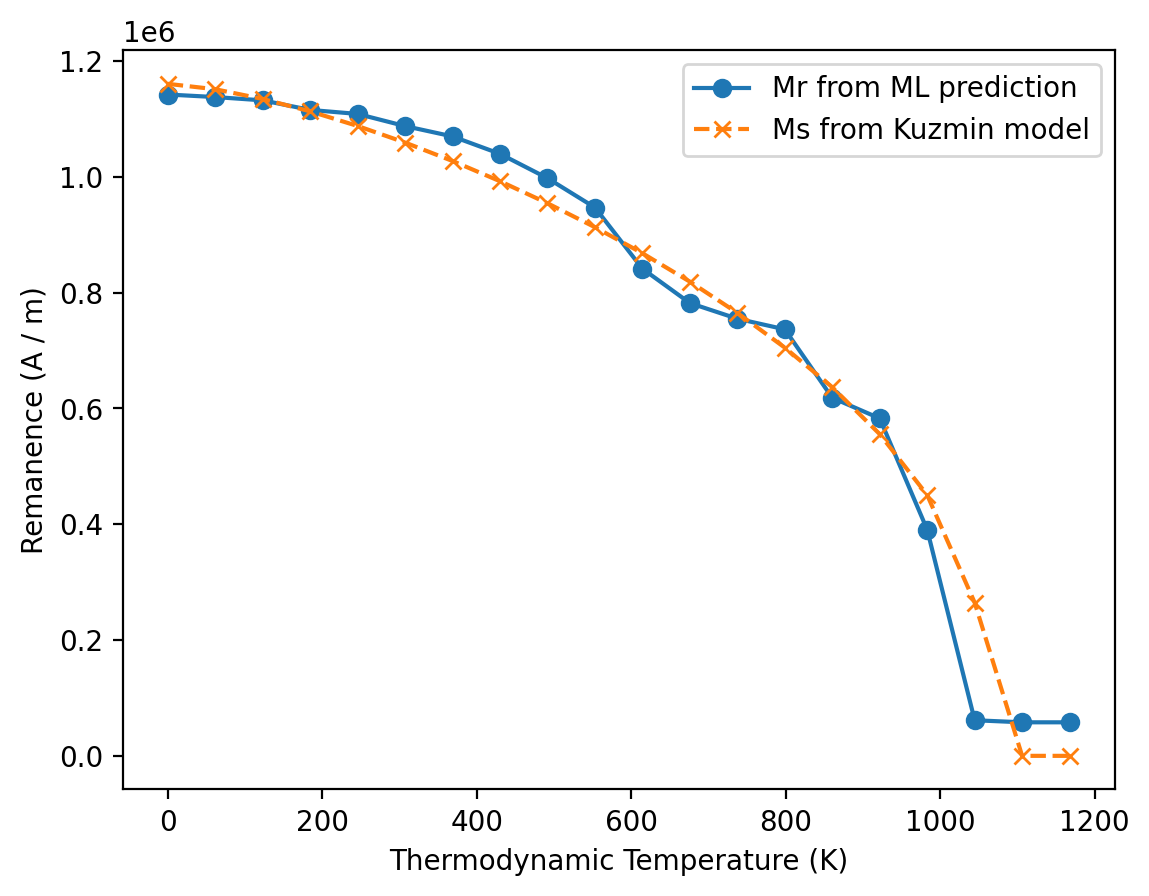

In [8]:
plt.plot(T, results_ml.Mr.value, linestyle="-", marker="o", label="Mr from ML prediction")
plt.plot(T, results_kuzmin.Ms(T).value, linestyle="--", marker="x", label="Ms from Kuzmin model")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Mr().axis_label)
plt.legend();

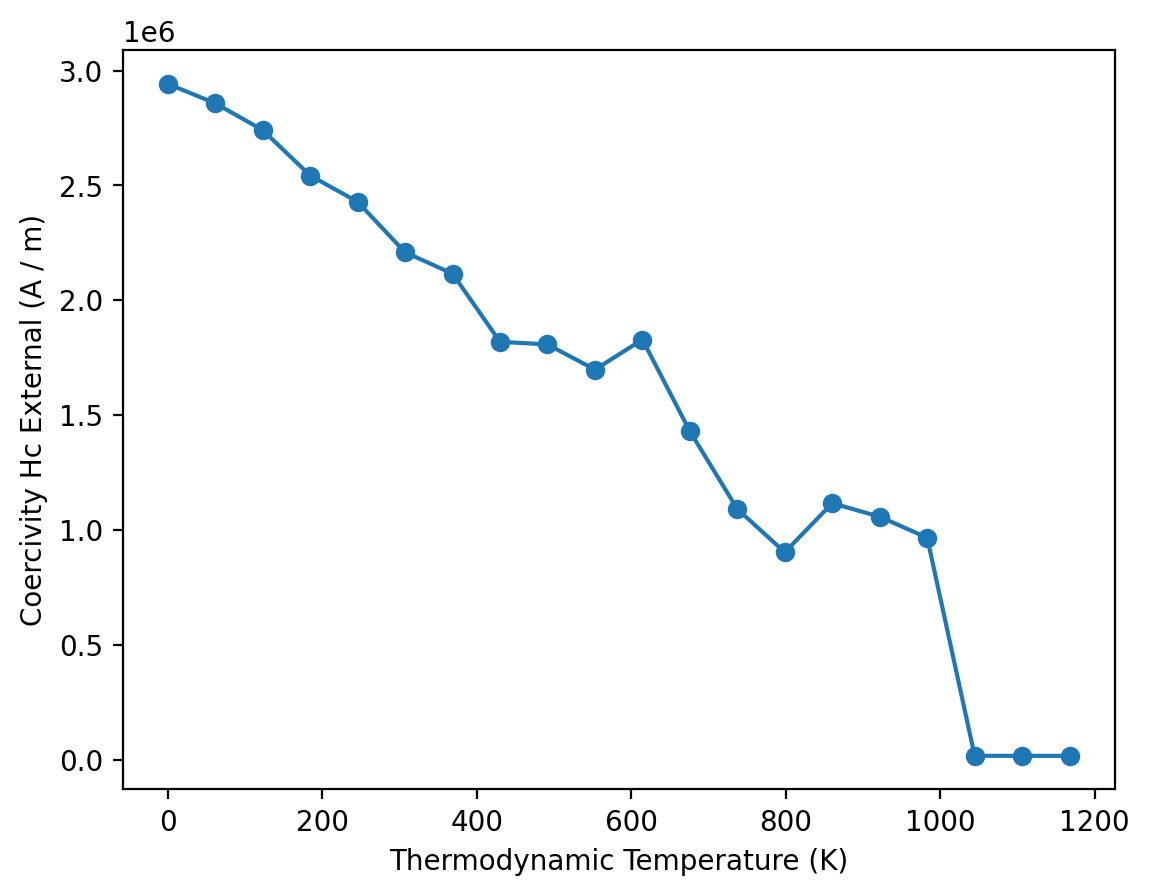

In [9]:
plt.plot(T, results_ml.Hc.value, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Hc().axis_label);

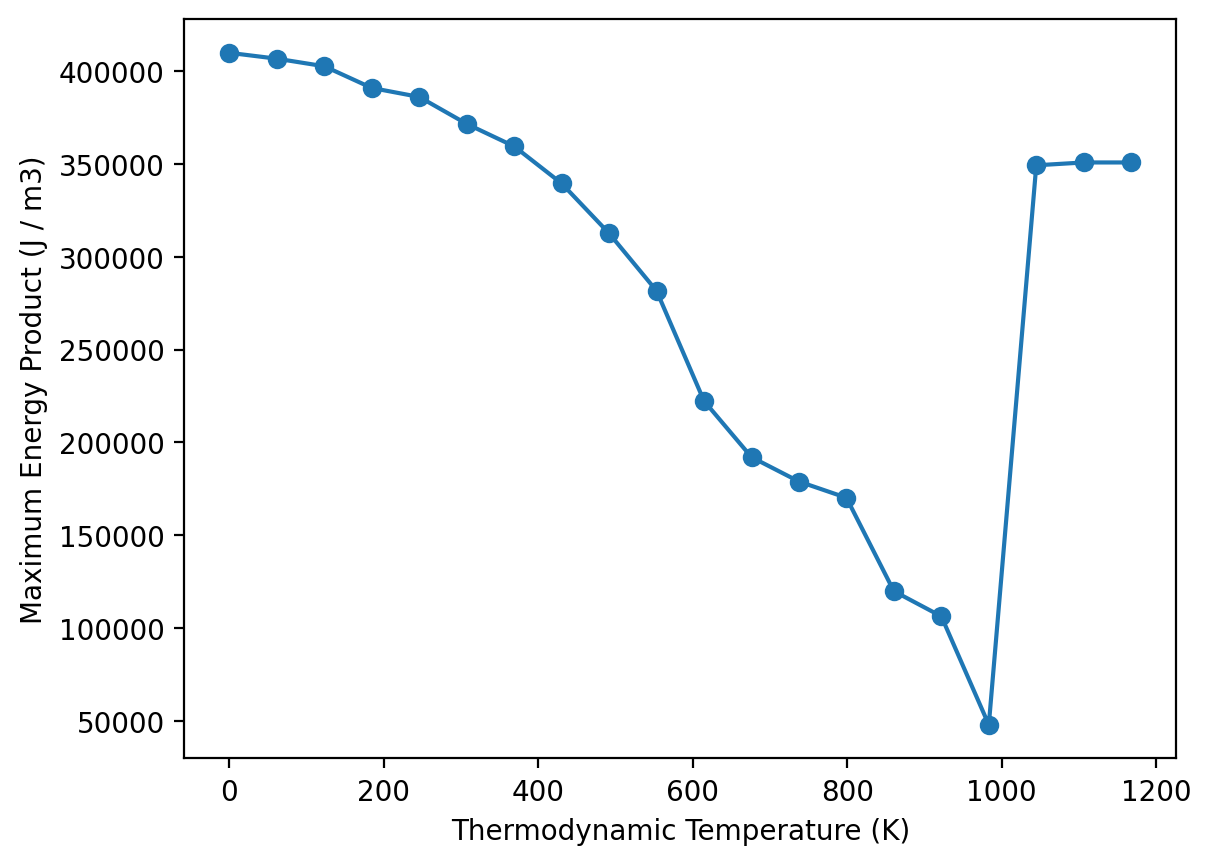

In [10]:
plt.plot(T, results_ml.BHmax.value, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.BHmax().axis_label);